## Modules

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [2]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [3]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [4]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [6]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [7]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [8]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [9]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


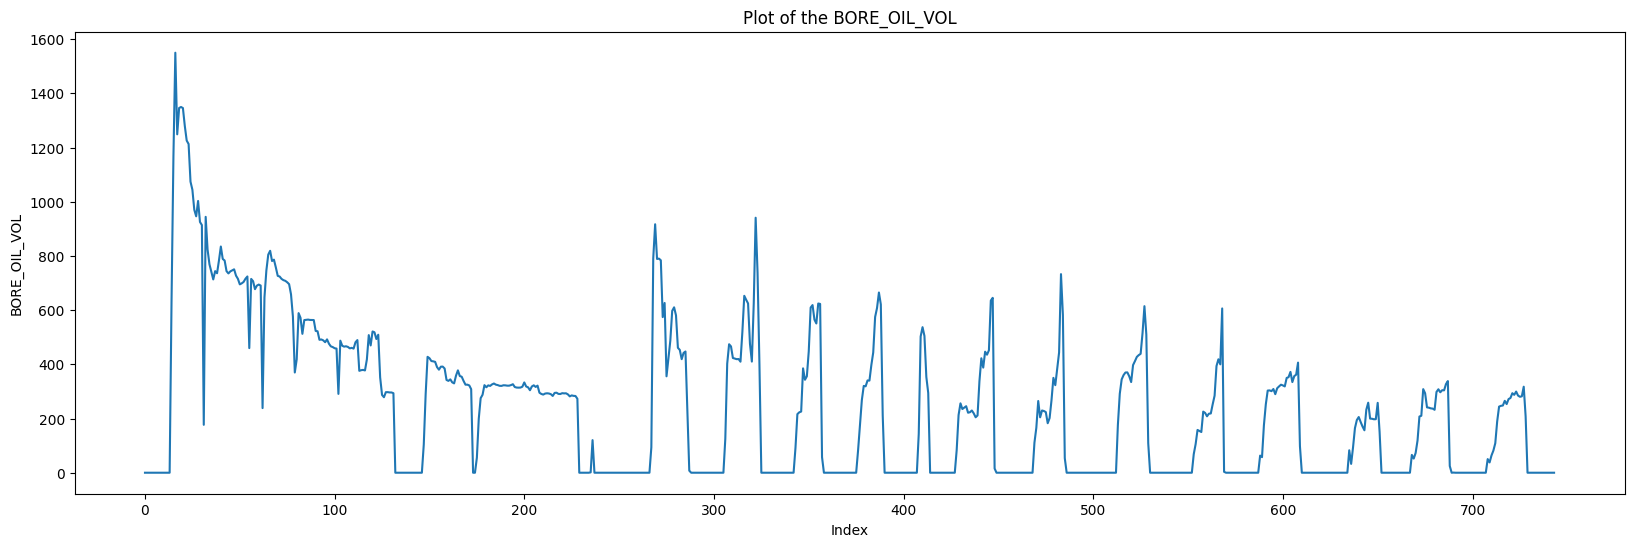

In [10]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [11]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [12]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


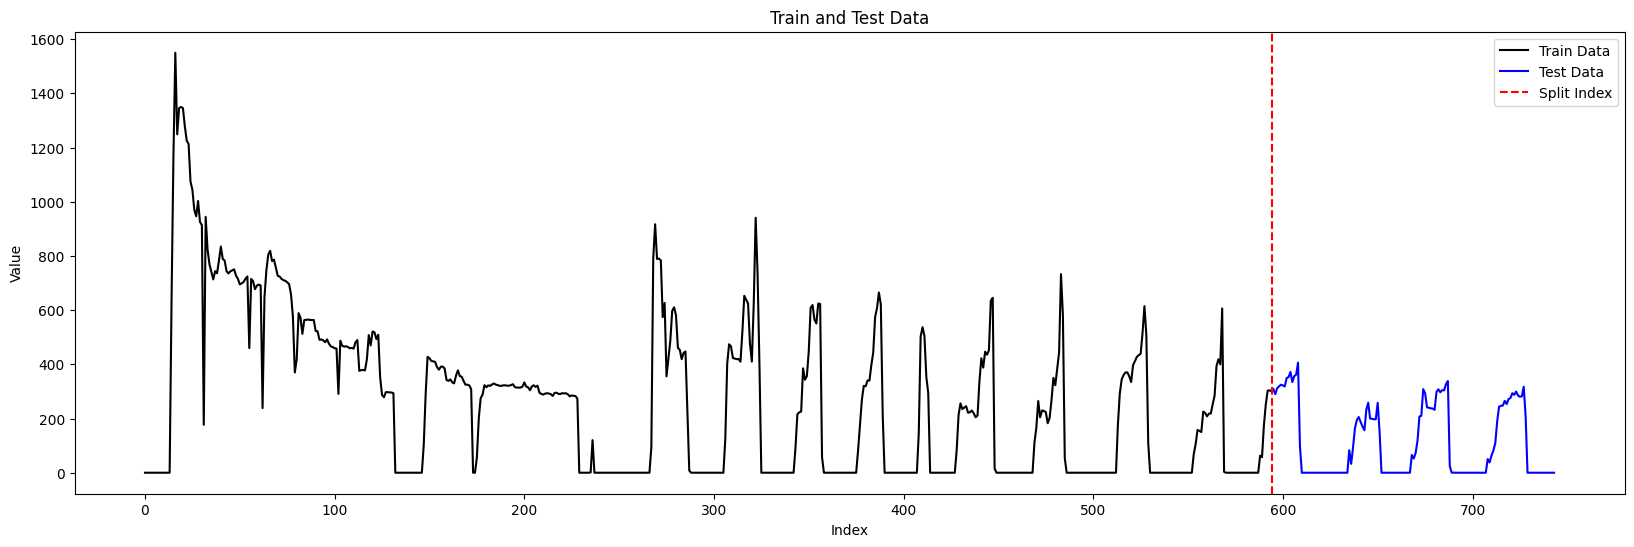

In [13]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [14]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [15]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [16]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [17]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [18]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [19]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [20]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [21]:
# pip install optuna
!pip install optuna-integration

In [22]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [23]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [24]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('batch_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [25]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-11-01 14:03:57,505] A new study created in memory with name: no-name-2d3b5ff2-66e3-4ab5-a80a-9f220ad138c9


In [26]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



INFO:tensorflow:Assets written to: ram://37df2e4f-46a6-4183-b8a7-08073e44687c/assets


INFO:tensorflow:Assets written to: ram://37df2e4f-46a6-4183-b8a7-08073e44687c/assets
[I 2023-11-01 14:24:36,628] Trial 0 finished with value: 0.016611963510513306 and parameters: {'window_size': 49, 'batch_size': 11, 'n_lstm_layers': 10, 'lstm_units': 238, 'learning_rate': 0.005558822154611125}. Best is trial 0 with value: 0.016611963510513306.


INFO:tensorflow:Assets written to: ram://34a1ee84-2af0-461a-9455-1cdbad686e35/assets


INFO:tensorflow:Assets written to: ram://34a1ee84-2af0-461a-9455-1cdbad686e35/assets
[I 2023-11-01 14:34:30,048] Trial 1 finished with value: 0.022685658186674118 and parameters: {'window_size': 28, 'batch_size': 17, 'n_lstm_layers': 11, 'lstm_units': 79, 'learning_rate': 0.00652032765955812}. Best is trial 0 with value: 0.016611963510513306.


INFO:tensorflow:Assets written to: ram://fe4f44f0-8e15-4194-814d-b4faa688eb6b/assets


INFO:tensorflow:Assets written to: ram://fe4f44f0-8e15-4194-814d-b4faa688eb6b/assets
[I 2023-11-01 14:49:18,641] Trial 2 finished with value: 0.02669980376958847 and parameters: {'window_size': 16, 'batch_size': 13, 'n_lstm_layers': 15, 'lstm_units': 121, 'learning_rate': 0.0002503399952034143}. Best is trial 0 with value: 0.016611963510513306.


INFO:tensorflow:Assets written to: ram://b8139ebf-a491-4241-8334-8b4698fb6186/assets


INFO:tensorflow:Assets written to: ram://b8139ebf-a491-4241-8334-8b4698fb6186/assets
[I 2023-11-01 15:10:39,217] Trial 3 finished with value: 0.028407596051692963 and parameters: {'window_size': 43, 'batch_size': 11, 'n_lstm_layers': 13, 'lstm_units': 116, 'learning_rate': 0.00011640896101322748}. Best is trial 0 with value: 0.016611963510513306.


INFO:tensorflow:Assets written to: ram://f1c61cbd-dd28-4ecb-9ad2-67f8c72bea30/assets


INFO:tensorflow:Assets written to: ram://f1c61cbd-dd28-4ecb-9ad2-67f8c72bea30/assets
[I 2023-11-01 15:49:32,359] Trial 4 finished with value: 0.018960146233439445 and parameters: {'window_size': 33, 'batch_size': 4, 'n_lstm_layers': 10, 'lstm_units': 134, 'learning_rate': 0.003344813170239631}. Best is trial 0 with value: 0.016611963510513306.
[I 2023-11-01 15:50:11,557] Trial 5 pruned. 


INFO:tensorflow:Assets written to: ram://76277c8d-fef2-4e7b-8789-5ae6b6068f6d/assets


INFO:tensorflow:Assets written to: ram://76277c8d-fef2-4e7b-8789-5ae6b6068f6d/assets
[I 2023-11-01 15:53:56,326] Trial 6 finished with value: 0.0013492910657078028 and parameters: {'window_size': 4, 'batch_size': 10, 'n_lstm_layers': 2, 'lstm_units': 33, 'learning_rate': 0.0020357307504160955}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://6cad18c0-2e0e-4726-9fd0-3970a851bcb8/assets


INFO:tensorflow:Assets written to: ram://6cad18c0-2e0e-4726-9fd0-3970a851bcb8/assets
[I 2023-11-01 15:57:21,482] Trial 7 finished with value: 0.002151662250980735 and parameters: {'window_size': 7, 'batch_size': 15, 'n_lstm_layers': 3, 'lstm_units': 46, 'learning_rate': 0.00911795024316519}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://8be17669-2bfb-4b11-a85c-19a45b2c93ba/assets


INFO:tensorflow:Assets written to: ram://8be17669-2bfb-4b11-a85c-19a45b2c93ba/assets
[I 2023-11-01 16:00:50,809] Trial 8 finished with value: 0.026783907786011696 and parameters: {'window_size': 55, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 116, 'learning_rate': 0.0012825155181195459}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:01:25,552] Trial 9 pruned. 


INFO:tensorflow:Assets written to: ram://b3c8610c-da35-469b-80bc-41f4ee068ffe/assets


INFO:tensorflow:Assets written to: ram://b3c8610c-da35-469b-80bc-41f4ee068ffe/assets
[I 2023-11-01 16:05:01,558] Trial 10 finished with value: 0.0015624134102836251 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 197, 'learning_rate': 0.0033613828831912593}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://acc7bd6d-b6da-4c0f-9386-6069e8dc1448/assets


INFO:tensorflow:Assets written to: ram://acc7bd6d-b6da-4c0f-9386-6069e8dc1448/assets
[I 2023-11-01 16:12:28,362] Trial 11 finished with value: 0.0028556829784065485 and parameters: {'window_size': 2, 'batch_size': 7, 'n_lstm_layers': 5, 'lstm_units': 204, 'learning_rate': 0.0035075300789988457}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:12:44,102] Trial 12 pruned. 
[I 2023-11-01 16:12:57,935] Trial 13 pruned. 


INFO:tensorflow:Assets written to: ram://9db96b58-7342-4f7f-9fa7-216c52b0c3ec/assets


INFO:tensorflow:Assets written to: ram://9db96b58-7342-4f7f-9fa7-216c52b0c3ec/assets
[I 2023-11-01 16:19:28,158] Trial 14 finished with value: 0.005919111426919699 and parameters: {'window_size': 24, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 252, 'learning_rate': 0.004417397292571289}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:19:59,257] Trial 15 pruned. 
[I 2023-11-01 16:20:31,244] Trial 16 pruned. 


INFO:tensorflow:Assets written to: ram://d84fdcba-1448-43a2-851e-920684c712f3/assets


INFO:tensorflow:Assets written to: ram://d84fdcba-1448-43a2-851e-920684c712f3/assets
[I 2023-11-01 16:23:26,513] Trial 17 finished with value: 0.0026774851139634848 and parameters: {'window_size': 19, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 209, 'learning_rate': 0.0014506825311850057}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:23:34,281] Trial 18 pruned. 
[I 2023-11-01 16:24:11,372] Trial 19 pruned. 
[I 2023-11-01 16:24:28,396] Trial 20 pruned. 
[I 2023-11-01 16:24:36,023] Trial 21 pruned. 
[I 2023-11-01 16:24:45,948] Trial 22 pruned. 


INFO:tensorflow:Assets written to: ram://bc3a40f4-c982-4e2c-b80b-75a7d98455c4/assets


INFO:tensorflow:Assets written to: ram://bc3a40f4-c982-4e2c-b80b-75a7d98455c4/assets
[I 2023-11-01 16:26:40,233] Trial 23 finished with value: 0.001756391255185008 and parameters: {'window_size': 7, 'batch_size': 18, 'n_lstm_layers': 1, 'lstm_units': 54, 'learning_rate': 0.008328373113755748}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:26:44,471] Trial 24 pruned. 
[I 2023-11-01 16:26:58,444] Trial 25 pruned. 
[I 2023-11-01 16:27:15,136] Trial 26 pruned. 


INFO:tensorflow:Assets written to: ram://4b601119-f7c0-412a-b9e6-52d23158bed6/assets


INFO:tensorflow:Assets written to: ram://4b601119-f7c0-412a-b9e6-52d23158bed6/assets
[I 2023-11-01 16:29:49,095] Trial 27 finished with value: 0.002780663315206766 and parameters: {'window_size': 13, 'batch_size': 13, 'n_lstm_layers': 1, 'lstm_units': 94, 'learning_rate': 0.005094367821797846}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:30:21,646] Trial 28 pruned. 
[I 2023-11-01 16:30:29,571] Trial 29 pruned. 
[I 2023-11-01 16:30:53,282] Trial 30 pruned. 
[I 2023-11-01 16:30:59,300] Trial 31 pruned. 
[I 2023-11-01 16:31:06,552] Trial 32 pruned. 
[I 2023-11-01 16:31:13,288] Trial 33 pruned. 
[I 2023-11-01 16:31:34,577] Trial 34 pruned. 
[I 2023-11-01 16:31:44,736] Trial 35 pruned. 
[I 2023-11-01 16:31:55,675] Trial 36 pruned. 
[I 2023-11-01 16:32:01,630] Trial 37 pruned. 
[I 2023-11-01 16:32:23,466] Trial 38 pruned. 


INFO:tensorflow:Assets written to: ram://84d78840-02dc-4976-a154-8351be666c2f/assets


INFO:tensorflow:Assets written to: ram://84d78840-02dc-4976-a154-8351be666c2f/assets
[I 2023-11-01 16:36:51,322] Trial 39 finished with value: 0.002207793528214097 and parameters: {'window_size': 36, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.0028583659374660708}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:37:20,963] Trial 40 pruned. 


INFO:tensorflow:Assets written to: ram://7637473c-6a7c-4b31-9339-37dc3784e8ba/assets


INFO:tensorflow:Assets written to: ram://7637473c-6a7c-4b31-9339-37dc3784e8ba/assets
[I 2023-11-01 16:41:54,000] Trial 41 finished with value: 0.0020326648373156786 and parameters: {'window_size': 39, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.0028692806975754103}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://e4b51d4a-42bd-4908-b115-07817ae78ecc/assets


INFO:tensorflow:Assets written to: ram://e4b51d4a-42bd-4908-b115-07817ae78ecc/assets
[I 2023-11-01 16:48:21,347] Trial 42 finished with value: 0.00198509288020432 and parameters: {'window_size': 45, 'batch_size': 8, 'n_lstm_layers': 2, 'lstm_units': 42, 'learning_rate': 0.0027257941442083208}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:48:27,664] Trial 43 pruned. 
[I 2023-11-01 16:48:38,761] Trial 44 pruned. 
[I 2023-11-01 16:48:49,844] Trial 45 pruned. 
[I 2023-11-01 16:48:53,752] Trial 46 pruned. 
[I 2023-11-01 16:49:10,196] Trial 47 pruned. 
[I 2023-11-01 16:49:26,765] Trial 48 pruned. 
[I 2023-11-01 16:49:45,754] Trial 49 pruned. 
[I 2023-11-01 16:49:54,146] Trial 50 pruned. 
[I 2023-11-01 16:50:00,274] Trial 51 pruned. 
[I 2023-11-01 16:50:05,448] Trial 52 pruned. 
[I 2023-11-01 16:50:14,907] Trial 53 pruned. 
[I 2023-11-01 16:50:24,862] Trial 54 pruned. 
[I 2023-11-01 16:50:29,052] Trial 55 pruned. 


INFO:tensorflow:Assets written to: ram://3989d7ed-4349-41bf-b447-638f4d14e82d/assets


INFO:tensorflow:Assets written to: ram://3989d7ed-4349-41bf-b447-638f4d14e82d/assets
[I 2023-11-01 16:54:20,856] Trial 56 finished with value: 0.0015078750438988209 and parameters: {'window_size': 4, 'batch_size': 10, 'n_lstm_layers': 2, 'lstm_units': 230, 'learning_rate': 0.0037158959040021625}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:54:27,248] Trial 57 pruned. 


INFO:tensorflow:Assets written to: ram://a0c537e5-32c1-4902-a2e9-35331710fb1d/assets


INFO:tensorflow:Assets written to: ram://a0c537e5-32c1-4902-a2e9-35331710fb1d/assets
[I 2023-11-01 16:59:34,336] Trial 58 finished with value: 0.0016860609175637364 and parameters: {'window_size': 2, 'batch_size': 8, 'n_lstm_layers': 3, 'lstm_units': 254, 'learning_rate': 0.0027561910691921853}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 16:59:45,943] Trial 59 pruned. 
[I 2023-11-01 16:59:54,415] Trial 60 pruned. 


INFO:tensorflow:Assets written to: ram://37cc5b8e-26d8-4076-92d0-f76f47409719/assets


INFO:tensorflow:Assets written to: ram://37cc5b8e-26d8-4076-92d0-f76f47409719/assets
[I 2023-11-01 17:09:45,067] Trial 61 finished with value: 0.0021956099662929773 and parameters: {'window_size': 38, 'batch_size': 7, 'n_lstm_layers': 3, 'lstm_units': 243, 'learning_rate': 0.0032987121559740046}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 17:09:48,954] Trial 62 pruned. 


INFO:tensorflow:Assets written to: ram://8f760941-1918-4e6c-b850-0b4824422a70/assets


INFO:tensorflow:Assets written to: ram://8f760941-1918-4e6c-b850-0b4824422a70/assets
[I 2023-11-01 17:13:31,172] Trial 63 finished with value: 0.0015428998740389943 and parameters: {'window_size': 3, 'batch_size': 10, 'n_lstm_layers': 2, 'lstm_units': 221, 'learning_rate': 0.0038163344719013927}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://86b2c57e-4804-46a7-9923-7fd6e396a761/assets


INFO:tensorflow:Assets written to: ram://86b2c57e-4804-46a7-9923-7fd6e396a761/assets
[I 2023-11-01 17:17:14,671] Trial 64 finished with value: 0.0015304754488170147 and parameters: {'window_size': 3, 'batch_size': 10, 'n_lstm_layers': 2, 'lstm_units': 234, 'learning_rate': 0.0038131677806856105}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 17:17:22,618] Trial 65 pruned. 
[I 2023-11-01 17:17:29,371] Trial 66 pruned. 
[I 2023-11-01 17:17:42,610] Trial 67 pruned. 
[I 2023-11-01 17:17:52,426] Trial 68 pruned. 
[I 2023-11-01 17:17:59,930] Trial 69 pruned. 
[I 2023-11-01 17:18:15,671] Trial 70 pruned. 


INFO:tensorflow:Assets written to: ram://29962c55-1bdc-456f-aa80-d82cac21083e/assets


INFO:tensorflow:Assets written to: ram://29962c55-1bdc-456f-aa80-d82cac21083e/assets
[I 2023-11-01 17:22:20,437] Trial 71 finished with value: 0.0014325615484267473 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 201, 'learning_rate': 0.004238167394903759}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://ad5eb6d6-51d2-427c-a705-1d35c1424c07/assets


INFO:tensorflow:Assets written to: ram://ad5eb6d6-51d2-427c-a705-1d35c1424c07/assets
[I 2023-11-01 17:26:25,899] Trial 72 finished with value: 0.001483256695792079 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 191, 'learning_rate': 0.0046460262631079045}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://8059dcf8-a108-4328-8ecb-a1ddfce337d3/assets


INFO:tensorflow:Assets written to: ram://8059dcf8-a108-4328-8ecb-a1ddfce337d3/assets
[I 2023-11-01 17:30:15,954] Trial 73 finished with value: 0.0014651654055342078 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 192, 'learning_rate': 0.004302942919581687}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://dc7107a6-7ef0-4dfa-86b5-d4f372cccb5f/assets


INFO:tensorflow:Assets written to: ram://dc7107a6-7ef0-4dfa-86b5-d4f372cccb5f/assets
[I 2023-11-01 17:34:15,047] Trial 74 finished with value: 0.0014870436862111092 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 188, 'learning_rate': 0.00435916093556522}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://b7fd5d3b-5d65-4ca6-8d02-4365de5cd2f1/assets


INFO:tensorflow:Assets written to: ram://b7fd5d3b-5d65-4ca6-8d02-4365de5cd2f1/assets
[I 2023-11-01 17:38:20,807] Trial 75 finished with value: 0.0015108450315892696 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 189, 'learning_rate': 0.004694092635433866}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 17:38:26,560] Trial 76 pruned. 
[I 2023-11-01 17:38:38,704] Trial 77 pruned. 
[I 2023-11-01 17:39:14,861] Trial 78 pruned. 
[I 2023-11-01 17:39:24,647] Trial 79 pruned. 
[I 2023-11-01 17:39:34,276] Trial 80 pruned. 


INFO:tensorflow:Assets written to: ram://e4279144-80b6-4633-b3a8-023fb39c7580/assets


INFO:tensorflow:Assets written to: ram://e4279144-80b6-4633-b3a8-023fb39c7580/assets
[I 2023-11-01 17:43:07,760] Trial 81 finished with value: 0.001442020875401795 and parameters: {'window_size': 4, 'batch_size': 10, 'n_lstm_layers': 2, 'lstm_units': 176, 'learning_rate': 0.004231788215561902}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 17:43:33,286] Trial 82 pruned. 
[I 2023-11-01 17:43:38,023] Trial 83 pruned. 
[I 2023-11-01 17:43:44,494] Trial 84 pruned. 


INFO:tensorflow:Assets written to: ram://d3122c1e-7c46-4cc2-b8b1-292b9169b2a6/assets


INFO:tensorflow:Assets written to: ram://d3122c1e-7c46-4cc2-b8b1-292b9169b2a6/assets
[I 2023-11-01 17:46:37,434] Trial 85 finished with value: 0.001371443155221641 and parameters: {'window_size': 4, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 197, 'learning_rate': 0.004402472334740351}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://d6934216-6204-4fcc-a27c-42e9c7539e43/assets


INFO:tensorflow:Assets written to: ram://d6934216-6204-4fcc-a27c-42e9c7539e43/assets
[I 2023-11-01 17:50:06,201] Trial 86 finished with value: 0.0013668163446709514 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 197, 'learning_rate': 0.004478492203232566}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 17:50:10,650] Trial 87 pruned. 


INFO:tensorflow:Assets written to: ram://5fe83157-6680-4af4-bbfa-6b8ae0990532/assets


INFO:tensorflow:Assets written to: ram://5fe83157-6680-4af4-bbfa-6b8ae0990532/assets
[I 2023-11-01 17:53:59,881] Trial 88 finished with value: 0.002001892775297165 and parameters: {'window_size': 8, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 207, 'learning_rate': 0.004399992906561332}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 17:54:08,159] Trial 89 pruned. 
[I 2023-11-01 17:54:12,834] Trial 90 pruned. 


INFO:tensorflow:Assets written to: ram://cc9f6691-707b-4b98-b216-a20774ef9f26/assets


INFO:tensorflow:Assets written to: ram://cc9f6691-707b-4b98-b216-a20774ef9f26/assets
[I 2023-11-01 17:58:12,262] Trial 91 finished with value: 0.0014590625651180744 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 188, 'learning_rate': 0.0047249570024123855}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 17:58:18,379] Trial 92 pruned. 
[I 2023-11-01 17:58:26,646] Trial 93 pruned. 
[I 2023-11-01 17:58:30,726] Trial 94 pruned. 
[I 2023-11-01 17:58:40,213] Trial 95 pruned. 
[I 2023-11-01 17:58:46,388] Trial 96 pruned. 
[I 2023-11-01 17:58:51,091] Trial 97 pruned. 
[I 2023-11-01 17:59:18,490] Trial 98 pruned. 
[I 2023-11-01 17:59:27,884] Trial 99 pruned. 
[I 2023-11-01 17:59:46,030] Trial 100 pruned. 
[I 2023-11-01 17:59:52,844] Trial 101 pruned. 
[I 2023-11-01 18:00:01,237] Trial 102 pruned. 
[I 2023-11-01 18:00:08,959] Trial 103 pruned. 
[I 2023-11-01 18:00:13,540] Trial 104 pruned. 


INFO:tensorflow:Assets written to: ram://bb41edf4-29bd-4ccc-abb0-1487de3a36fa/assets


INFO:tensorflow:Assets written to: ram://bb41edf4-29bd-4ccc-abb0-1487de3a36fa/assets
[I 2023-11-01 18:04:41,276] Trial 105 finished with value: 0.0014520662371069193 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 2, 'lstm_units': 200, 'learning_rate': 0.00395940891329192}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 18:04:47,091] Trial 106 pruned. 
[I 2023-11-01 18:04:56,125] Trial 107 pruned. 
[I 2023-11-01 18:05:02,204] Trial 108 pruned. 
[I 2023-11-01 18:05:10,973] Trial 109 pruned. 
[I 2023-11-01 18:05:16,913] Trial 110 pruned. 
[I 2023-11-01 18:05:23,367] Trial 111 pruned. 


INFO:tensorflow:Assets written to: ram://b22c020a-5c2b-45fe-b487-7a660f5d5f45/assets


INFO:tensorflow:Assets written to: ram://b22c020a-5c2b-45fe-b487-7a660f5d5f45/assets
[I 2023-11-01 18:08:23,953] Trial 112 finished with value: 0.0016031614504754543 and parameters: {'window_size': 3, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 190, 'learning_rate': 0.003908247992773365}. Best is trial 6 with value: 0.0013492910657078028.
[I 2023-11-01 18:08:31,930] Trial 113 pruned. 


INFO:tensorflow:Assets written to: ram://efd98132-aa22-4149-b07c-93b8bed1e772/assets


INFO:tensorflow:Assets written to: ram://efd98132-aa22-4149-b07c-93b8bed1e772/assets
[I 2023-11-01 18:13:08,190] Trial 114 finished with value: 0.00251959590241313 and parameters: {'window_size': 2, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 164, 'learning_rate': 0.004585073265925221}. Best is trial 6 with value: 0.0013492910657078028.


INFO:tensorflow:Assets written to: ram://39507474-866d-4df7-86ce-771a58c6f687/assets


INFO:tensorflow:Assets written to: ram://39507474-866d-4df7-86ce-771a58c6f687/assets
[I 2023-11-01 18:15:58,109] Trial 115 finished with value: 0.0013190334429964423 and parameters: {'window_size': 4, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 200, 'learning_rate': 0.0035922760596100484}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:16:02,349] Trial 116 pruned. 


INFO:tensorflow:Assets written to: ram://fc54440c-3e07-4c40-95b7-14425138de27/assets


INFO:tensorflow:Assets written to: ram://fc54440c-3e07-4c40-95b7-14425138de27/assets
[I 2023-11-01 18:18:48,859] Trial 117 finished with value: 0.0014864486875012517 and parameters: {'window_size': 3, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 200, 'learning_rate': 0.003120201804390476}. Best is trial 115 with value: 0.0013190334429964423.


INFO:tensorflow:Assets written to: ram://ab187fa7-7388-42e1-b1b4-a56cca52188e/assets


INFO:tensorflow:Assets written to: ram://ab187fa7-7388-42e1-b1b4-a56cca52188e/assets
[I 2023-11-01 18:21:23,527] Trial 118 finished with value: 0.0014929143944755197 and parameters: {'window_size': 3, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 200, 'learning_rate': 0.0032825185950677007}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:21:27,795] Trial 119 pruned. 
[I 2023-11-01 18:22:06,089] Trial 120 pruned. 


INFO:tensorflow:Assets written to: ram://76dfffc7-6079-4932-b219-e0ce0fdd7e84/assets


INFO:tensorflow:Assets written to: ram://76dfffc7-6079-4932-b219-e0ce0fdd7e84/assets
[I 2023-11-01 18:24:54,277] Trial 121 finished with value: 0.0014873052714392543 and parameters: {'window_size': 3, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 198, 'learning_rate': 0.003159639958342063}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:24:58,550] Trial 122 pruned. 
[I 2023-11-01 18:25:05,131] Trial 123 pruned. 


INFO:tensorflow:Assets written to: ram://673397d7-87b2-42c9-9896-5c469208e9d1/assets


INFO:tensorflow:Assets written to: ram://673397d7-87b2-42c9-9896-5c469208e9d1/assets
[I 2023-11-01 18:28:13,692] Trial 124 finished with value: 0.0014098347164690495 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 197, 'learning_rate': 0.004004531263286446}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:28:20,121] Trial 125 pruned. 
[I 2023-11-01 18:28:27,327] Trial 126 pruned. 
[I 2023-11-01 18:28:33,736] Trial 127 pruned. 


INFO:tensorflow:Assets written to: ram://0ac77163-ae6e-42b9-8658-5f7faa7b3617/assets


INFO:tensorflow:Assets written to: ram://0ac77163-ae6e-42b9-8658-5f7faa7b3617/assets
[I 2023-11-01 18:32:23,250] Trial 128 finished with value: 0.0013194784987717867 and parameters: {'window_size': 4, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 196, 'learning_rate': 0.0035414415943938416}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:32:27,674] Trial 129 pruned. 
[I 2023-11-01 18:32:32,333] Trial 130 pruned. 
[I 2023-11-01 18:32:39,775] Trial 131 pruned. 
[I 2023-11-01 18:32:45,074] Trial 132 pruned. 
[I 2023-11-01 18:32:51,951] Trial 133 pruned. 
[I 2023-11-01 18:32:56,250] Trial 134 pruned. 
[I 2023-11-01 18:33:02,612] Trial 135 pruned. 
[I 2023-11-01 18:33:10,521] Trial 136 pruned. 
[I 2023-11-01 18:33:18,604] Trial 137 pruned. 
[I 2023-11-01 18:33:22,918] Trial 138 pruned. 
[I 2023-11-01 18:33:29,154] Trial 139 pruned. 
[I 2023-11-01 18:33:33,703] Trial 140 pruned. 


INFO:tensorflow:Assets written to: ram://2fa9539c-4cb0-489a-ab89-a44ca13c8eaf/assets


INFO:tensorflow:Assets written to: ram://2fa9539c-4cb0-489a-ab89-a44ca13c8eaf/assets
[I 2023-11-01 18:36:00,811] Trial 141 finished with value: 0.0013680156553164124 and parameters: {'window_size': 3, 'batch_size': 12, 'n_lstm_layers': 1, 'lstm_units': 198, 'learning_rate': 0.0031833853487954213}. Best is trial 115 with value: 0.0013190334429964423.


INFO:tensorflow:Assets written to: ram://085e2b85-bcaf-4622-8e35-5b01325dcd15/assets


INFO:tensorflow:Assets written to: ram://085e2b85-bcaf-4622-8e35-5b01325dcd15/assets
[I 2023-11-01 18:39:04,857] Trial 142 finished with value: 0.0014046886935830116 and parameters: {'window_size': 3, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 196, 'learning_rate': 0.0033452703507899787}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:39:09,412] Trial 143 pruned. 
[I 2023-11-01 18:39:15,602] Trial 144 pruned. 
[I 2023-11-01 18:39:34,732] Trial 145 pruned. 


INFO:tensorflow:Assets written to: ram://c5170540-9095-4ead-ae3f-4b8ed19d3e4f/assets


INFO:tensorflow:Assets written to: ram://c5170540-9095-4ead-ae3f-4b8ed19d3e4f/assets
[I 2023-11-01 18:41:50,674] Trial 146 finished with value: 0.001376455184072256 and parameters: {'window_size': 4, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 214, 'learning_rate': 0.002987655498699028}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:41:56,661] Trial 147 pruned. 
[I 2023-11-01 18:42:01,303] Trial 148 pruned. 
[I 2023-11-01 18:42:09,102] Trial 149 pruned. 
[I 2023-11-01 18:42:13,541] Trial 150 pruned. 
[I 2023-11-01 18:42:18,324] Trial 151 pruned. 
[I 2023-11-01 18:42:24,560] Trial 152 pruned. 


INFO:tensorflow:Assets written to: ram://fdbcd6bd-c0ec-432f-aefd-2dff7458b2f1/assets


INFO:tensorflow:Assets written to: ram://fdbcd6bd-c0ec-432f-aefd-2dff7458b2f1/assets
[I 2023-11-01 18:45:56,190] Trial 153 finished with value: 0.0015560995088890195 and parameters: {'window_size': 2, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 193, 'learning_rate': 0.0031047462637835256}. Best is trial 115 with value: 0.0013190334429964423.
[I 2023-11-01 18:46:02,172] Trial 154 pruned. 


INFO:tensorflow:Assets written to: ram://1b4d33b4-ebe2-4e54-929f-96a5ce0465e5/assets


INFO:tensorflow:Assets written to: ram://1b4d33b4-ebe2-4e54-929f-96a5ce0465e5/assets
[I 2023-11-01 18:50:02,306] Trial 155 finished with value: 0.0008375669131055474 and parameters: {'window_size': 59, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 111, 'learning_rate': 0.0038789243023851245}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://ce264db0-2774-49f9-9ab8-1802af2dfc2b/assets


INFO:tensorflow:Assets written to: ram://ce264db0-2774-49f9-9ab8-1802af2dfc2b/assets
[I 2023-11-01 18:54:23,892] Trial 156 finished with value: 0.001608214806765318 and parameters: {'window_size': 57, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 210, 'learning_rate': 0.0039746106850127435}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 18:54:29,800] Trial 157 pruned. 
[I 2023-11-01 18:54:41,274] Trial 158 pruned. 
[I 2023-11-01 18:54:49,386] Trial 159 pruned. 
[I 2023-11-01 18:54:53,340] Trial 160 pruned. 
[I 2023-11-01 18:54:57,951] Trial 161 pruned. 


INFO:tensorflow:Assets written to: ram://ec754b60-f3e9-40ef-a737-c63d919c5bf0/assets


INFO:tensorflow:Assets written to: ram://ec754b60-f3e9-40ef-a737-c63d919c5bf0/assets
[I 2023-11-01 18:58:30,597] Trial 162 finished with value: 0.0015767430886626244 and parameters: {'window_size': 3, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 190, 'learning_rate': 0.004212649706865271}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 18:58:37,617] Trial 163 pruned. 


INFO:tensorflow:Assets written to: ram://d60f9534-4a3a-455c-8d51-841937fbebef/assets


INFO:tensorflow:Assets written to: ram://d60f9534-4a3a-455c-8d51-841937fbebef/assets
[I 2023-11-01 19:01:09,644] Trial 164 finished with value: 0.0021774894557893276 and parameters: {'window_size': 2, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 205, 'learning_rate': 0.0038391590043128547}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:01:16,134] Trial 165 pruned. 
[I 2023-11-01 19:01:20,354] Trial 166 pruned. 
[I 2023-11-01 19:01:26,980] Trial 167 pruned. 
[I 2023-11-01 19:01:31,341] Trial 168 pruned. 
[I 2023-11-01 19:01:37,298] Trial 169 pruned. 
[I 2023-11-01 19:01:42,442] Trial 170 pruned. 
[I 2023-11-01 19:01:49,241] Trial 171 pruned. 
[I 2023-11-01 19:01:54,399] Trial 172 pruned. 
[I 2023-11-01 19:02:00,963] Trial 173 pruned. 
[I 2023-11-01 19:02:09,075] Trial 174 pruned. 
[I 2023-11-01 19:02:13,547] Trial 175 pruned. 
[I 2023-11-01 19:02:19,736] Trial 176 pruned. 
[I 2023-11-01 19:02:39,991] Trial 177 pruned. 


INFO:tensorflow:Assets written to: ram://89b69a4f-f4a3-452e-945a-02bfb697c860/assets


INFO:tensorflow:Assets written to: ram://89b69a4f-f4a3-452e-945a-02bfb697c860/assets
[I 2023-11-01 19:06:43,750] Trial 178 finished with value: 0.0021095839329063892 and parameters: {'window_size': 2, 'batch_size': 10, 'n_lstm_layers': 3, 'lstm_units': 208, 'learning_rate': 0.004459418178960445}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:06:49,843] Trial 179 pruned. 
[I 2023-11-01 19:06:54,829] Trial 180 pruned. 
[I 2023-11-01 19:06:59,080] Trial 181 pruned. 
[I 2023-11-01 19:07:03,566] Trial 182 pruned. 
[I 2023-11-01 19:07:09,567] Trial 183 pruned. 


INFO:tensorflow:Assets written to: ram://724d785b-b045-4beb-9c61-3ea1de2433f2/assets


INFO:tensorflow:Assets written to: ram://724d785b-b045-4beb-9c61-3ea1de2433f2/assets
[I 2023-11-01 19:09:47,186] Trial 184 finished with value: 0.0014273867709562182 and parameters: {'window_size': 3, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 194, 'learning_rate': 0.0038122034719120287}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://af01c0cf-9507-44e9-9475-8016a7bff5d8/assets


INFO:tensorflow:Assets written to: ram://af01c0cf-9507-44e9-9475-8016a7bff5d8/assets
[I 2023-11-01 19:14:27,877] Trial 185 finished with value: 0.0030190302059054375 and parameters: {'window_size': 60, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 192, 'learning_rate': 0.00373985448020248}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:14:33,878] Trial 186 pruned. 
[I 2023-11-01 19:14:38,507] Trial 187 pruned. 
[I 2023-11-01 19:15:01,483] Trial 188 pruned. 
[I 2023-11-01 19:15:11,331] Trial 189 pruned. 
[I 2023-11-01 19:15:19,989] Trial 190 pruned. 


INFO:tensorflow:Assets written to: ram://6a376926-eddb-4503-a9f8-355b83dc788b/assets


INFO:tensorflow:Assets written to: ram://6a376926-eddb-4503-a9f8-355b83dc788b/assets
[I 2023-11-01 19:18:08,919] Trial 191 finished with value: 0.0014477737713605165 and parameters: {'window_size': 3, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 197, 'learning_rate': 0.0027005978470192042}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:18:13,744] Trial 192 pruned. 
[I 2023-11-01 19:18:18,917] Trial 193 pruned. 
[I 2023-11-01 19:18:25,216] Trial 194 pruned. 


INFO:tensorflow:Assets written to: ram://59c44c1f-8c0a-4ecb-8543-92c5095117e2/assets


INFO:tensorflow:Assets written to: ram://59c44c1f-8c0a-4ecb-8543-92c5095117e2/assets
[I 2023-11-01 19:21:14,181] Trial 195 finished with value: 0.0013797158608213067 and parameters: {'window_size': 3, 'batch_size': 10, 'n_lstm_layers': 1, 'lstm_units': 199, 'learning_rate': 0.002260225948603569}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:21:18,722] Trial 196 pruned. 
[I 2023-11-01 19:21:22,959] Trial 197 pruned. 
[I 2023-11-01 19:21:28,039] Trial 198 pruned. 
[I 2023-11-01 19:21:33,619] Trial 199 pruned. 
[I 2023-11-01 19:21:37,886] Trial 200 pruned. 
[I 2023-11-01 19:21:44,529] Trial 201 pruned. 
[I 2023-11-01 19:22:20,103] Trial 202 pruned. 
[I 2023-11-01 19:22:24,307] Trial 203 pruned. 
[I 2023-11-01 19:22:29,528] Trial 204 pruned. 
[I 2023-11-01 19:22:35,813] Trial 205 pruned. 


INFO:tensorflow:Assets written to: ram://74ba9829-6bc8-4197-8dc3-a27b8b35c21f/assets


INFO:tensorflow:Assets written to: ram://74ba9829-6bc8-4197-8dc3-a27b8b35c21f/assets
[I 2023-11-01 19:25:36,603] Trial 206 finished with value: 0.0014581665163859725 and parameters: {'window_size': 3, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 191, 'learning_rate': 0.003083424929436326}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:25:40,808] Trial 207 pruned. 
[I 2023-11-01 19:25:55,891] Trial 208 pruned. 
[I 2023-11-01 19:26:00,268] Trial 209 pruned. 
[I 2023-11-01 19:26:04,863] Trial 210 pruned. 
[I 2023-11-01 19:26:11,069] Trial 211 pruned. 
[I 2023-11-01 19:26:17,102] Trial 212 pruned. 
[I 2023-11-01 19:26:21,463] Trial 213 pruned. 
[I 2023-11-01 19:26:27,731] Trial 214 pruned. 
[I 2023-11-01 19:26:55,462] Trial 215 pruned. 


INFO:tensorflow:Assets written to: ram://a5b3f066-ae64-49d8-8dd9-fa969f1d8dd8/assets


INFO:tensorflow:Assets written to: ram://a5b3f066-ae64-49d8-8dd9-fa969f1d8dd8/assets
[I 2023-11-01 19:30:27,692] Trial 216 finished with value: 0.0013802346074953675 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 202, 'learning_rate': 0.004221741874601955}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:30:32,006] Trial 217 pruned. 
[I 2023-11-01 19:30:36,227] Trial 218 pruned. 


INFO:tensorflow:Assets written to: ram://f8f2250d-91b5-4ca6-a256-60a1949e793e/assets


INFO:tensorflow:Assets written to: ram://f8f2250d-91b5-4ca6-a256-60a1949e793e/assets
[I 2023-11-01 19:34:05,435] Trial 219 finished with value: 0.0014211756642907858 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 199, 'learning_rate': 0.004117574182671781}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:34:09,842] Trial 220 pruned. 
[I 2023-11-01 19:34:14,562] Trial 221 pruned. 
[I 2023-11-01 19:34:19,643] Trial 222 pruned. 


INFO:tensorflow:Assets written to: ram://0e00ed31-ade3-42f2-9f57-ac5db75cb4fd/assets


INFO:tensorflow:Assets written to: ram://0e00ed31-ade3-42f2-9f57-ac5db75cb4fd/assets
[I 2023-11-01 19:37:50,168] Trial 223 finished with value: 0.0014184311730787158 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 203, 'learning_rate': 0.0039942986700127}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:37:56,545] Trial 224 pruned. 
[I 2023-11-01 19:38:00,483] Trial 225 pruned. 


INFO:tensorflow:Assets written to: ram://dcd4d614-01bc-45d8-974e-ce1e7ee86a92/assets


INFO:tensorflow:Assets written to: ram://dcd4d614-01bc-45d8-974e-ce1e7ee86a92/assets
[I 2023-11-01 19:41:48,983] Trial 226 finished with value: 0.0013443540083244443 and parameters: {'window_size': 4, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 212, 'learning_rate': 0.003929784660144207}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:41:53,444] Trial 227 pruned. 
[I 2023-11-01 19:41:58,649] Trial 228 pruned. 
[I 2023-11-01 19:42:03,229] Trial 229 pruned. 


INFO:tensorflow:Assets written to: ram://d0986d3a-2210-4987-a3a3-50a752b4c26d/assets


INFO:tensorflow:Assets written to: ram://d0986d3a-2210-4987-a3a3-50a752b4c26d/assets
[I 2023-11-01 19:45:33,043] Trial 230 finished with value: 0.0013413357082754374 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 207, 'learning_rate': 0.003919479984351082}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://a0ec97cd-ddc2-440c-917a-dff15d300ab4/assets


INFO:tensorflow:Assets written to: ram://a0ec97cd-ddc2-440c-917a-dff15d300ab4/assets
[I 2023-11-01 19:48:57,008] Trial 231 finished with value: 0.0013965158723294735 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 208, 'learning_rate': 0.003801349511122162}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://ed4c22aa-337a-4bc2-8959-6d2fb39f5f9e/assets


INFO:tensorflow:Assets written to: ram://ed4c22aa-337a-4bc2-8959-6d2fb39f5f9e/assets
[I 2023-11-01 19:52:43,353] Trial 232 finished with value: 0.0013084564125165343 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 216, 'learning_rate': 0.0037793442811831003}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 19:52:48,228] Trial 233 pruned. 
[I 2023-11-01 19:52:52,197] Trial 234 pruned. 


INFO:tensorflow:Assets written to: ram://d7c66f71-d5b9-45d0-a1b1-a48476e55e24/assets


INFO:tensorflow:Assets written to: ram://d7c66f71-d5b9-45d0-a1b1-a48476e55e24/assets
[I 2023-11-01 19:56:28,299] Trial 235 finished with value: 0.0013859473401680589 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 218, 'learning_rate': 0.0037222478884238247}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://2aa12fd4-08d5-479f-bc90-78a9d989fbb5/assets


INFO:tensorflow:Assets written to: ram://2aa12fd4-08d5-479f-bc90-78a9d989fbb5/assets
[I 2023-11-01 19:59:57,214] Trial 236 finished with value: 0.0013696301029995084 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 218, 'learning_rate': 0.0035711119610380413}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 20:00:01,629] Trial 237 pruned. 


INFO:tensorflow:Assets written to: ram://0e0a8e0a-8215-43e2-a052-eeb3be4c7526/assets


INFO:tensorflow:Assets written to: ram://0e0a8e0a-8215-43e2-a052-eeb3be4c7526/assets
[I 2023-11-01 20:03:55,078] Trial 238 finished with value: 0.0013500056229531765 and parameters: {'window_size': 4, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 221, 'learning_rate': 0.003757948304951675}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 20:03:59,829] Trial 239 pruned. 
[I 2023-11-01 20:04:04,263] Trial 240 pruned. 


INFO:tensorflow:Assets written to: ram://d5ce5c11-9cbb-45e5-82c4-667a3d46d0f5/assets


INFO:tensorflow:Assets written to: ram://d5ce5c11-9cbb-45e5-82c4-667a3d46d0f5/assets
[I 2023-11-01 20:07:33,483] Trial 241 finished with value: 0.0013124060351401567 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 217, 'learning_rate': 0.003801358116547289}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://5f449af4-3bf8-4d83-8fad-9261d00ce0b3/assets


INFO:tensorflow:Assets written to: ram://5f449af4-3bf8-4d83-8fad-9261d00ce0b3/assets
[I 2023-11-01 20:11:01,991] Trial 242 finished with value: 0.0013549660798162222 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 218, 'learning_rate': 0.003797171431319411}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://8da60dd7-959a-48cf-9283-ef0c6c421466/assets


INFO:tensorflow:Assets written to: ram://8da60dd7-959a-48cf-9283-ef0c6c421466/assets
[I 2023-11-01 20:14:32,246] Trial 243 finished with value: 0.0013175510102882981 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 221, 'learning_rate': 0.003818999343613607}. Best is trial 155 with value: 0.0008375669131055474.


INFO:tensorflow:Assets written to: ram://ee7cb232-c68a-44ab-8dee-5aa446fecb19/assets


INFO:tensorflow:Assets written to: ram://ee7cb232-c68a-44ab-8dee-5aa446fecb19/assets
[I 2023-11-01 20:17:56,520] Trial 244 finished with value: 0.0014122460270300508 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 220, 'learning_rate': 0.003773141722311028}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 20:18:00,516] Trial 245 pruned. 
[I 2023-11-01 20:18:05,315] Trial 246 pruned. 
[I 2023-11-01 20:18:10,942] Trial 247 pruned. 


INFO:tensorflow:Assets written to: ram://b2c9232b-f64a-404b-830a-270be6e1fb2d/assets


INFO:tensorflow:Assets written to: ram://b2c9232b-f64a-404b-830a-270be6e1fb2d/assets
[I 2023-11-01 20:21:42,456] Trial 248 finished with value: 0.0013545829569920897 and parameters: {'window_size': 4, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 218, 'learning_rate': 0.0034582409707573595}. Best is trial 155 with value: 0.0008375669131055474.
[I 2023-11-01 20:21:47,448] Trial 249 pruned. 


In [27]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 59, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 111, 'learning_rate': 0.0038789243023851245}
Best Validation Loss: 0.0008375669131055474


In [28]:
study.best_params['n_lstm_layers']

1

In [29]:
study.best_trial.number

155

In [30]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['batch_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [31]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [32]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.0002273917921203635
Test MSE: 0.001685050010422907


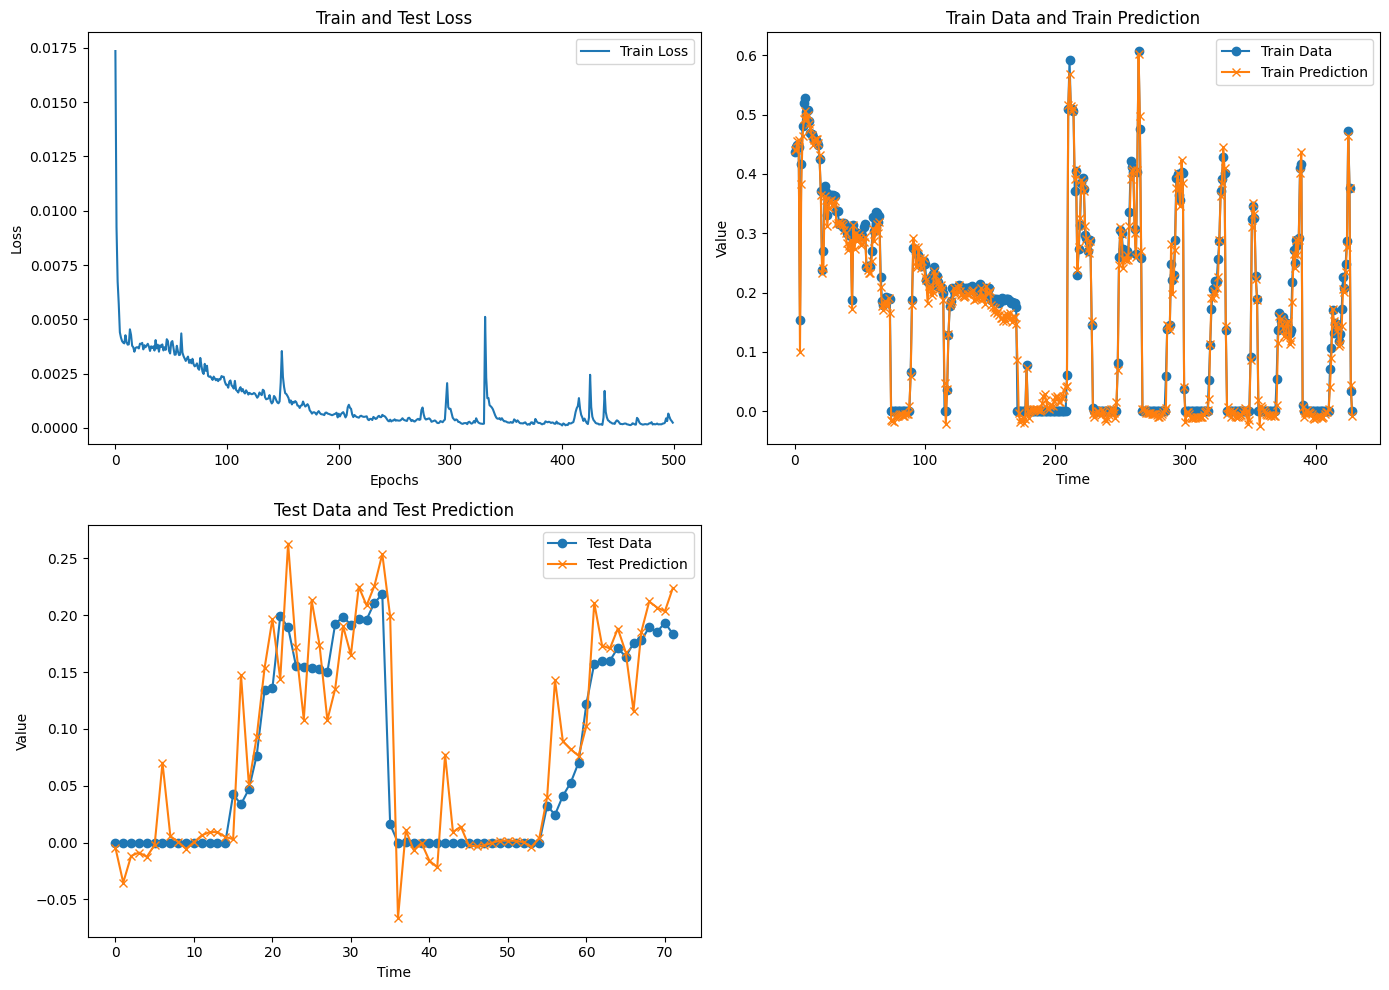

In [33]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

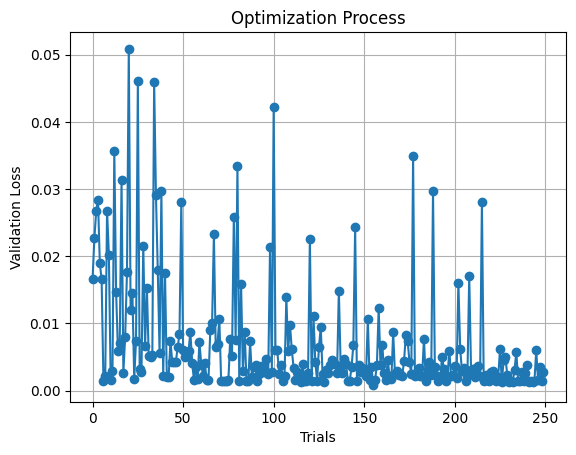

In [34]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

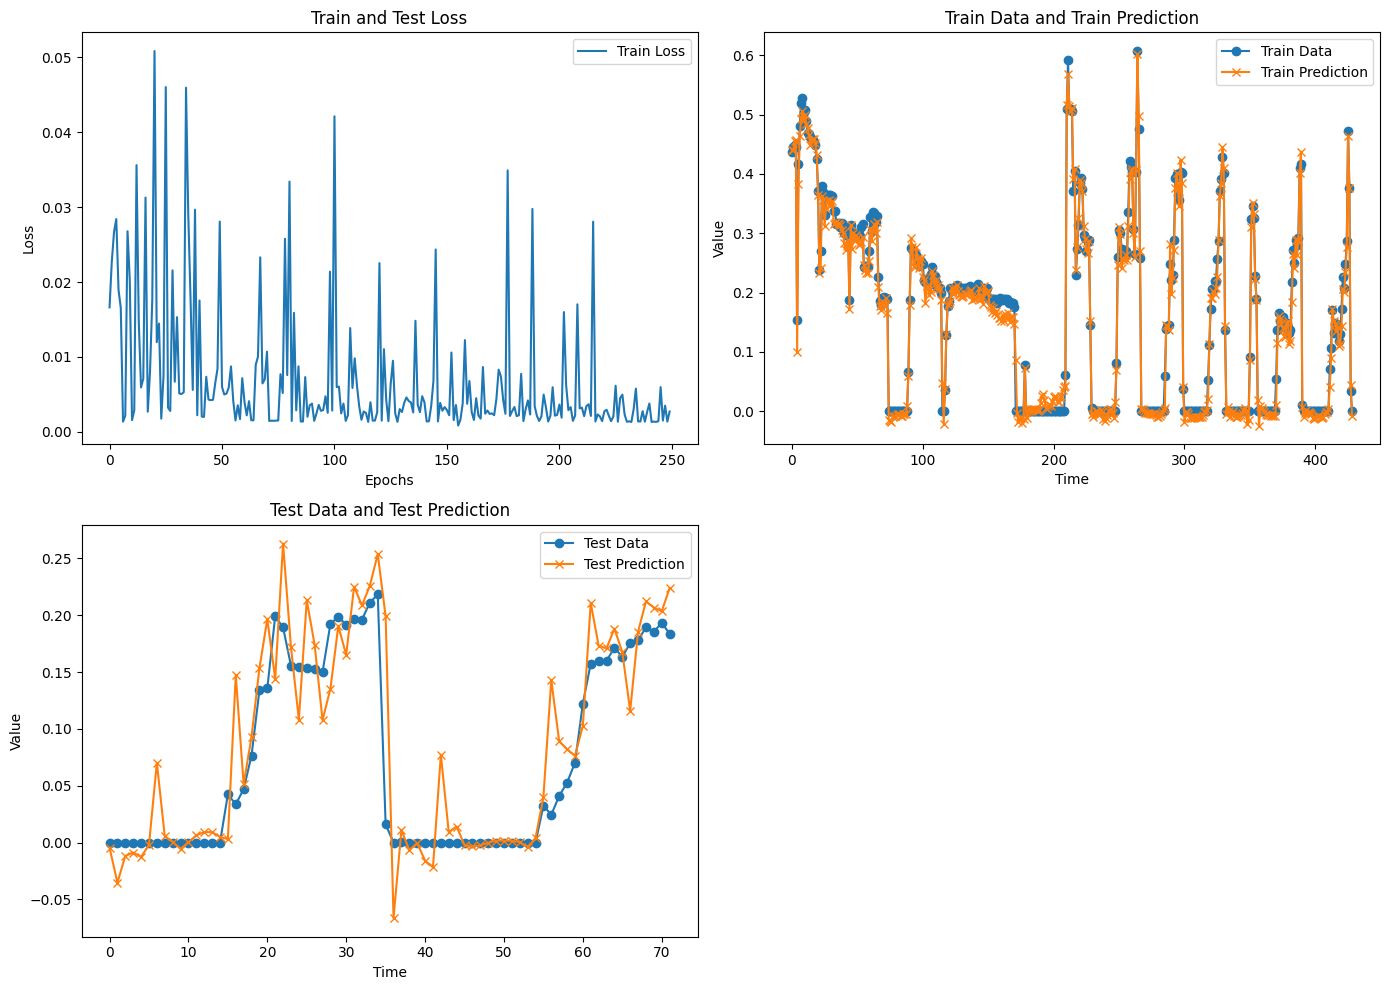

In [35]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [36]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [38]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [39]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [40]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [41]:
# from keras.utils.vis_utils import plot_model


In [42]:
# plot_model(model_LSTM)

In [43]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [44]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [45]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.004586420477584549
Test MSE: 0.000849974756157965


In [46]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [47]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.000227  0.001685
1  Baseline   0.004586  0.000850


In [48]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [49]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 49, 'batch_size': 11, 'n_lstm_layers': 10, 'lstm_units': 238, 'learning_rate': 0.005558822154611125}
Trial 2: {'window_size': 28, 'batch_size': 17, 'n_lstm_layers': 11, 'lstm_units': 79, 'learning_rate': 0.00652032765955812}
Trial 3: {'window_size': 16, 'batch_size': 13, 'n_lstm_layers': 15, 'lstm_units': 121, 'learning_rate': 0.0002503399952034143}
Trial 4: {'window_size': 43, 'batch_size': 11, 'n_lstm_layers': 13, 'lstm_units': 116, 'learning_rate': 0.00011640896101322748}
Trial 5: {'window_size': 33, 'batch_size': 4, 'n_lstm_layers': 10, 'lstm_units': 134, 'learning_rate': 0.003344813170239631}
Trial 6: {'window_size': 40, 'batch_size': 10, 'n_lstm_layers': 19, 'lstm_units': 32, 'learning_rate': 0.0021233032617606114}
Trial 7: {'window_size': 4, 'batch_size': 10, 'n_lstm_layers': 2, 'lstm_units': 33, 'learning_rate': 0.0020357307504160955}
Trial 8: {'window_size': 7, 'batch_size': 15, 'n_lstm_layers': 3, 'lstm_units'